In [1]:
import os
for c in os.listdir("data/flower_photos"):
    print(c, len(os.listdir(f"data/flower_photos/{c}")))

daisy 633
dandelion 898
roses 641
sunflowers 699
tulips 799


In [2]:
import time
from dataclasses import dataclass
from typing import List, Dict, Any

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

%matplotlib inline

data_dir = "data/flower_photos"
image_size = 128
batch_size = 32

default_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Default device:", default_device)

Default device: cuda


AUGMENTARE MAI AGRESIVA -> ColorJitter

In [4]:
from torch.utils.data import Subset

def get_dataloaders():
    # for the experiments between 0-10
    # train_transform = transforms.Compose([
    #     transforms.Resize((image_size, image_size)),
    #     transforms.RandomHorizontalFlip(),
    #     transforms.RandomRotation(20),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                          std=[0.229, 0.224, 0.225]),
    # ])
    #
    # val_transform = transforms.Compose([
    #     transforms.Resize((image_size, image_size)),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                          std=[0.229, 0.224, 0.225]),
    # ])

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    # dataset de baza, fara transform (doar pentru split de indecsi)
    base_dataset = datasets.ImageFolder(root=data_dir)
    class_names = base_dataset.classes
    num_classes = len(class_names)

    print("Classes:", class_names)
    print("Number of images:", len(base_dataset))

    train_ratio = 0.8
    train_size = int(train_ratio * len(base_dataset))
    val_size = len(base_dataset) - train_size

    train_subset_base, val_subset_base = random_split(
        base_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42),
    )

    train_indices = train_subset_base.indices
    val_indices = val_subset_base.indices

    full_train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
    full_val_dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)

    train_dataset = Subset(full_train_dataset, train_indices)
    val_dataset = Subset(full_val_dataset, val_indices)

    print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    print("Number of train batches:", len(train_loader))
    print("Number of val batches:", len(val_loader))

    return train_loader, val_loader, class_names, num_classes


# sanity check
train_loader, val_loader, class_names, num_classes = get_dataloaders()


Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of images: 3670
Train size: 2936, Val size: 734
Number of train batches: 92
Number of val batches: 23


In [5]:
def get_activation(name: str):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    if name == "tanh":
        return nn.Tanh()
    if name == "leakyrelu":
        return nn.LeakyReLU(0.1)
    raise ValueError(f"Unknown activation {name}")


class FlexibleCNN(nn.Module):
    """
    Model flexibil:
    - 0–4 convolutional layers
    - opT BatchNorm
    - opt MaxPooling
    - 1–2 fully connected (hidden) layers
    """

    def __init__(
        self,
        num_classes: int,
        num_conv_layers: int = 3,
        num_hidden_layers: int = 1,
        hidden_dim: int = 256,
        use_batchnorm: bool = True,
        use_pooling: bool = True,
        activation: str = "relu",
    ):
        super().__init__()

        self.num_conv_layers = num_conv_layers
        self.num_hidden_layers = num_hidden_layers
        self.use_batchnorm = use_batchnorm
        self.use_pooling = use_pooling
        self.activation = get_activation(activation)

        layers = []
        in_channels = 3
        out_channels = 32

        if num_conv_layers > 0:
            for i in range(num_conv_layers):
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
                if use_batchnorm:
                    layers.append(nn.BatchNorm2d(out_channels))
                layers.append(self.activation)
                if use_pooling:
                    layers.append(nn.MaxPool2d(2))

                in_channels = out_channels
                out_channels *= 2

            layers.append(nn.AdaptiveAvgPool2d((4, 4)))
            self.features = nn.Sequential(*layers)

            last_channels = in_channels
            fc_in_dim = last_channels * 4 * 4
        else:
            self.features = nn.Identity()
            fc_in_dim = 3 * image_size * image_size

        self.flatten = nn.Flatten()

        fc_layers = []
        if num_hidden_layers == 1:
            fc_layers.append(nn.Linear(fc_in_dim, hidden_dim))
            fc_layers.append(self.activation)
            fc_layers.append(nn.Dropout(0.5))
            fc_layers.append(nn.Linear(hidden_dim, num_classes))
        elif num_hidden_layers == 2:
            fc_layers.append(nn.Linear(fc_in_dim, hidden_dim))
            fc_layers.append(self.activation)
            fc_layers.append(nn.Dropout(0.5))
            fc_layers.append(nn.Linear(hidden_dim, hidden_dim // 2))
            fc_layers.append(self.activation)
            fc_layers.append(nn.Dropout(0.5))
            fc_layers.append(nn.Linear(hidden_dim // 2, num_classes))
        else:
            raise ValueError("num_hidden_layers must be 1 or 2")

        self.classifier = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
# test
test_model = FlexibleCNN(num_classes=num_classes, num_conv_layers=2, num_hidden_layers=1)
print(test_model)

FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)


In [6]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, l1_lambda: float = 0.0):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    start_time = time.time()

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        if l1_lambda > 0.0:
            l1_norm = 0.0
            for p in model.parameters():
                l1_norm += p.abs().sum()
            loss = loss + l1_lambda * l1_norm

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    epoch_time = time.time() - start_time
    return epoch_loss, epoch_acc, epoch_time


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    return epoch_loss, epoch_acc


def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds

In [7]:
def plot_history(history, title_prefix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_confusion(all_labels, all_preds, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def print_model_parameters(model):
    print("\n Model parameters (weights & biases)")
    for name, param in model.named_parameters():
        print(f"{name}: shape={tuple(param.shape)}")

In [8]:
@dataclass
class ExperimentConfig:
    name: str
    num_conv_layers: int
    num_hidden_layers: int
    hidden_dim: int
    use_batchnorm: bool
    use_pooling: bool
    activation: str
    learning_rate: float
    l2_lambda: float
    l1_lambda: float
    num_epochs: int
    patience: int = 5

      #todo for 12 --- NOI: pt. fine-tuning mai agresiv ---
    label_smoothing: float = 0.1
    use_scheduler: bool = False

def get_experiments() -> List[ExperimentConfig]:
    return [
        # 0) MLP – baseline (fără conv, doar fully connected)
        ExperimentConfig(
            name="0",
            num_conv_layers=0,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=False,   # nu are sens la MLP-ul ăsta simplu aici
            use_pooling=False,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),

        ExperimentConfig(
            name="1",
            num_conv_layers=1,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,   # nu are sens la MLP-ul ăsta simplu aici
            use_pooling=True,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),


        # 2) CNN mediu – 2 conv, fără BN, cu pooling
        ExperimentConfig(
            name="2",
            num_conv_layers=2,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=True,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),

        # 3) CNN 2 conv, LR mai mic – efectul lui learning rate
        ExperimentConfig(
            name="3",
            num_conv_layers=2,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=12,
        ),

        # 4) CNN 3 conv + BatchNorm + pooling – modelul foarte bun (fără L1)
        ExperimentConfig(
            name="4",
            num_conv_layers=3,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=5e-4,
            l1_lambda=0.0,
            num_epochs=15,
        ),

        # 5) CNN 3 conv + BatchNorm + pooling, dar cu LeakyReLU
        ExperimentConfig(
            name="5",
            num_conv_layers=3,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=True,
            use_pooling=True,
            activation="leakyrelu",
            learning_rate=3e-4,
            l2_lambda=5e-4,
            l1_lambda=0.0,
            num_epochs=15,
        ),

        # 6) CNN mai adânc – 4 conv + BN + pooling, hidden layer mai mare
        ExperimentConfig(
            name="6",
            num_conv_layers=4,
            num_hidden_layers=1,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,     # pooling ca să nu explodeze runtime-ul
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=1e-3,       # L2 mai puternic ca să nu suprainvețe
            l1_lambda=0.0,
            num_epochs=15,
        ),

        # 7) CNN fără pooling – cerința "mit / ohne Pooling"
        ExperimentConfig(
            name="7",
            num_conv_layers=2,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=False,    # aici e diferența importantă
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=8,         # poți crește dacă vezi că nu converge
        ),

        # 8) CNN cu L1 activ – cerința "Werte für L1-Regularisierung"
        ExperimentConfig(
            name="8",             # <-- aici era dublura, acum e unic
            num_conv_layers=3,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=5e-4,
            l1_lambda=1e-5,       # L1 activ (valoare mică)
            num_epochs=15,
        ),

        # 9) MLP cu tanh – pentru a avea încă o activare diferită
        ExperimentConfig(
            name="9",
            num_conv_layers=0,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=False,
            use_pooling=False,
            activation="tanh",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),

        # 10) Ultimate CNN – 4 conv + BN + pooling, ReLU, L2 + L1, lr mic
        ExperimentConfig(
            name="10",
            num_conv_layers=4,
            num_hidden_layers=1,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=2e-4,
            l2_lambda=7e-4,
            l1_lambda=1e-5,
            num_epochs=25,
        ),
        ExperimentConfig(
            name="11",
            num_conv_layers=4,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=1.5e-4,
            l2_lambda=6e-4,
            l1_lambda=5e-6,
            num_epochs=30,
        ),
        ExperimentConfig(
            name="12",
            num_conv_layers=4,
            num_hidden_layers=1,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=1.8e-4,
            l2_lambda=5e-4,
            l1_lambda=0.0,
            num_epochs=40,
            patience = 8,
            label_smoothing=0.05,
            use_scheduler=True,
        ),

    ]


experiments = get_experiments()
print(experiments)


[ExperimentConfig(name='0', num_conv_layers=0, num_hidden_layers=2, hidden_dim=512, use_batchnorm=False, use_pooling=False, activation='relu', learning_rate=0.001, l2_lambda=0.0001, l1_lambda=0.0, num_epochs=10, patience=5, label_smoothing=0.1, use_scheduler=False), ExperimentConfig(name='1', num_conv_layers=1, num_hidden_layers=1, hidden_dim=256, use_batchnorm=False, use_pooling=True, activation='relu', learning_rate=0.001, l2_lambda=0.0001, l1_lambda=0.0, num_epochs=10, patience=5, label_smoothing=0.1, use_scheduler=False), ExperimentConfig(name='2', num_conv_layers=2, num_hidden_layers=1, hidden_dim=256, use_batchnorm=False, use_pooling=True, activation='relu', learning_rate=0.001, l2_lambda=0.0001, l1_lambda=0.0, num_epochs=10, patience=5, label_smoothing=0.1, use_scheduler=False), ExperimentConfig(name='3', num_conv_layers=2, num_hidden_layers=1, hidden_dim=256, use_batchnorm=False, use_pooling=True, activation='relu', learning_rate=0.0003, l2_lambda=0.0001, l1_lambda=0.0, num_epo

In [9]:
def run_experiment(
    cfg: ExperimentConfig,
    train_loader: DataLoader,
    val_loader: DataLoader,
    class_names: List[str],
    num_classes: int,
    device: torch.device,
) -> Dict[str, Any]:
    print("\n" + "=" * 80)
    print(f"Starting experiment: {cfg.name} on device {device}")
    print("=" * 80)

    model = FlexibleCNN(
        num_classes=num_classes,
        num_conv_layers=cfg.num_conv_layers,
        num_hidden_layers=cfg.num_hidden_layers,
        hidden_dim=cfg.hidden_dim,
        use_batchnorm=cfg.use_batchnorm,
        use_pooling=cfg.use_pooling,
        activation=cfg.activation,
    ).to(device)

    print(model)
#todo
  #  criterion = nn.CrossEntropyLoss()
  #  criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)


    optimizer = optim.Adam(
        model.parameters(),
        lr=cfg.learning_rate,
        weight_decay=cfg.l2_lambda,
    )

    #todo for 12
    if cfg.use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
           optimizer,
           T_max=cfg.num_epochs,
        )
    else:
        scheduler = None



    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "epoch_time": [],
    }

    best_val_loss = float("inf")
    best_val_acc = 0.0
    best_state_dict = None
    best_epoch = 0
    no_improve_epochs = 0

    total_start = time.time()

    for epoch in range(1, cfg.num_epochs + 1):
        print(f"\nEpoch {epoch}/{cfg.num_epochs}")
        print("-" * 40)

        train_loss, train_acc, train_time = train_one_epoch(
            model, train_loader, criterion, optimizer, device, l1_lambda=cfg.l1_lambda
        )
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["epoch_time"].append(train_time)

        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
        print(f"Epoch train time: {train_time:.1f} s")

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_state_dict = model.state_dict()
            best_epoch = epoch
            no_improve_epochs = 0
            print(f"new best model (val_loss={best_val_loss:.4f}, val_acc={best_val_acc:.4f})")
        else:
            no_improve_epochs += 1
            print(f"no improvement for {no_improve_epochs} epoch(s)")

                     #todo for 12
        if scheduler is not None:
            scheduler.step()

        if no_improve_epochs >= cfg.patience:
            print(f" early stopping triggered at epoch {epoch}")
            break

    total_time = time.time() - total_start
    print(f"\nTRAINING FINISHED FOR {cfg.name}")
    print(f"Best epoch: {best_epoch} / {cfg.num_epochs}")
    print(f"Best val_loss: {best_val_loss:.4f} | Best val_acc: {best_val_acc:.4f}")
    print(f"Total training time: {total_time:.1f} s")

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    # Final prediction + macro-F1
    all_labels, all_preds = get_predictions(model, val_loader, device)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Macro-F1 on validation: {macro_f1:.4f}")

    print_model_parameters(model)

    plot_history(history, title_prefix=cfg.name)
    plot_confusion(all_labels, all_preds, class_names, title=f"{cfg.name} - Confusion Matrix")

    result = {
        "config": cfg,
        "history": history,
        "macro_f1": macro_f1,
        "best_val_acc": best_val_acc,
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "total_time": total_time,
    }
    return result


def compare_cpu_gpu(cfg: ExperimentConfig, train_loader, val_loader, class_names, num_classes):
    cpu_device = torch.device("cpu")
    gpu_device = torch.device("cuda") if torch.cuda.is_available() else None

    print("\n===== CPU vs GPU comparison for config:", cfg.name, "=====")

    print("\n### Running on CPU ###")
    res_cpu = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, cpu_device)

    if gpu_device is not None:
        print("\n### Running on GPU ###")
        res_gpu = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, gpu_device)

        print("\n=== CPU vs GPU summary ===")
        print(f"CPU total time: {res_cpu['total_time']:.1f} s")
        print(f"GPU total time: {res_gpu['total_time']:.1f} s")
        speedup = res_cpu["total_time"] / res_gpu["total_time"] if res_gpu["total_time"] > 0 else None
        if speedup is not None:
            print(f"Approx. speedup: {speedup:.2f}x")
    else:
        print("No GPU available for comparison.")



Starting experiment: 0 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=49152, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/10
----------------------------------------
Train loss: 5.7558 | Train acc: 0.2711
Val loss: 1.6131 | Val acc: 0.3052
Epoch train time: 25.3 s
new best model (val_loss=1.6131, val_acc=0.3052)

Epoch 2/10
----------------------------------------
Train loss: 1.7635 | Train acc: 0.2820
Val loss: 1.5533 | Val acc: 0.3501
Epoch train time: 17.2 s
new best model (val_loss=1.5533, val_acc=0.3501)

Epoch 3/10
----------------------------------------
Train loss: 1.6173 | Train acc: 0.2895
Val loss: 1.5008 | Val acc: 0.

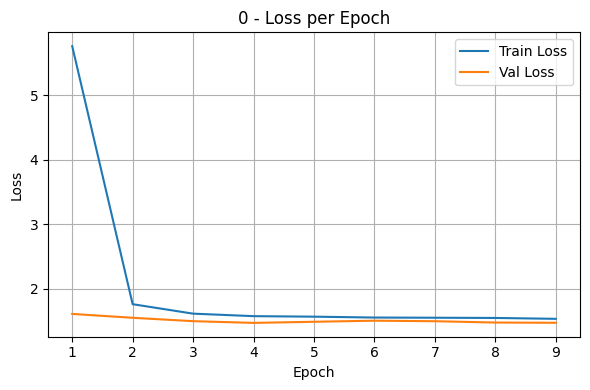

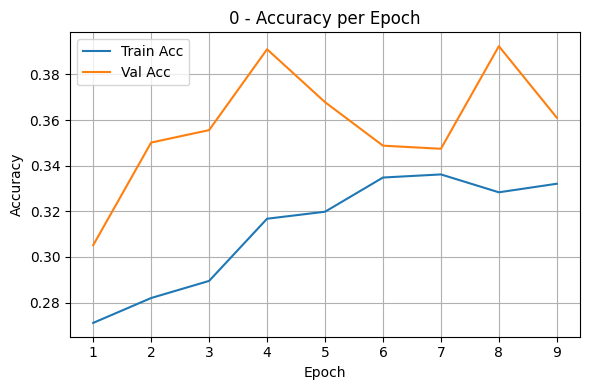

<Figure size 600x600 with 0 Axes>

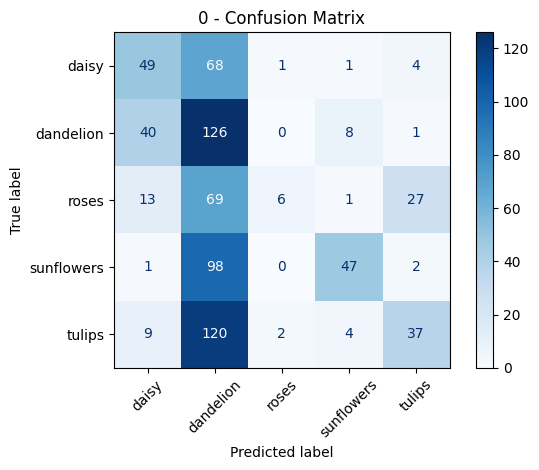

In [19]:
# MLP baseline
cfg = experiments[0]
result0 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)


Starting experiment: 1 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/10
----------------------------------------
Train loss: 1.4573 | Train acc: 0.3743
Val loss: 1.2724 | Val acc: 0.5300
Epoch train time: 20.5 s
new best model (val_loss=1.2724, val_acc=0.5300)

Epoch 2/10
----------------------------------------
Train loss: 1.3669 | Train acc: 0.4513
Val loss: 1.2371 | Val acc: 0.5272
Epoch train time: 19.3 s
new best model (val_loss=1.2371, val_acc=0.5272)

Epoch 3/10
---

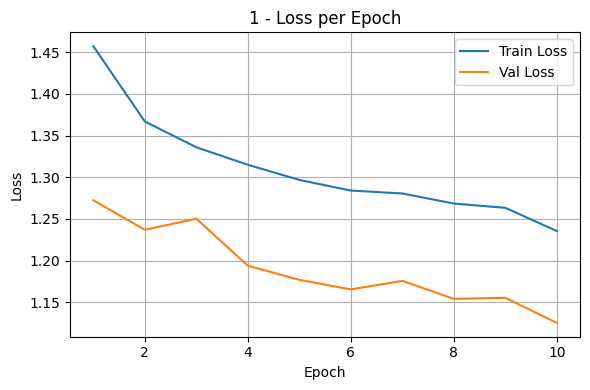

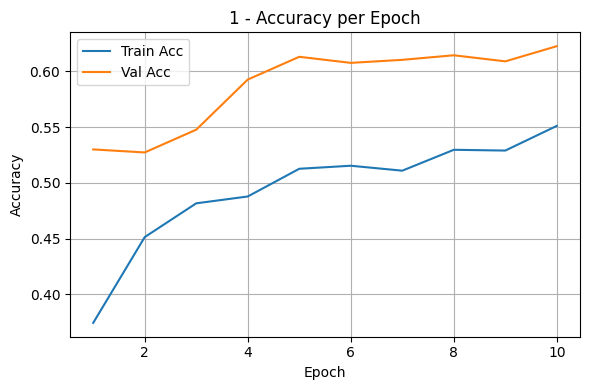

<Figure size 600x600 with 0 Axes>

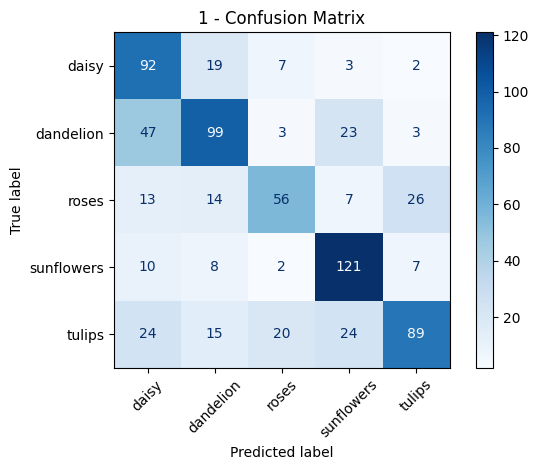

In [22]:
cfg = experiments[1]
result0 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)


Starting experiment: 2 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/10
----------------------------------------
Train loss: 1.4613 | Train acc: 0.3692
Val loss: 1.2647 | Val acc: 0.5572
Epoch train time: 18.7 s
new best model (val_loss=1.2647, val_acc=0.5572)

Epoch 2/10
----------------------------

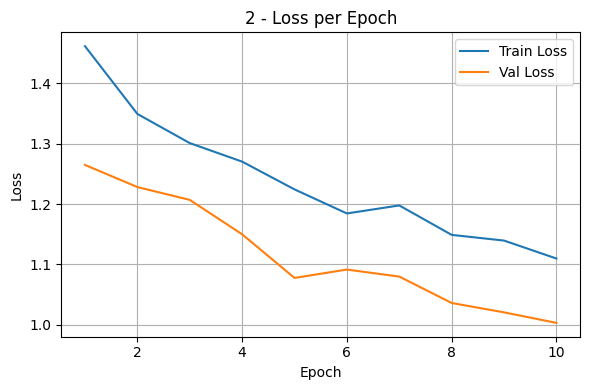

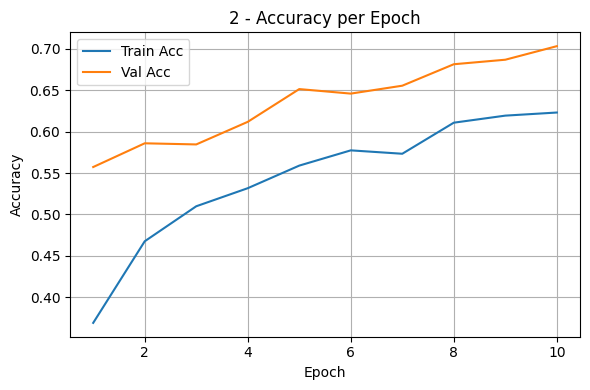

<Figure size 600x600 with 0 Axes>

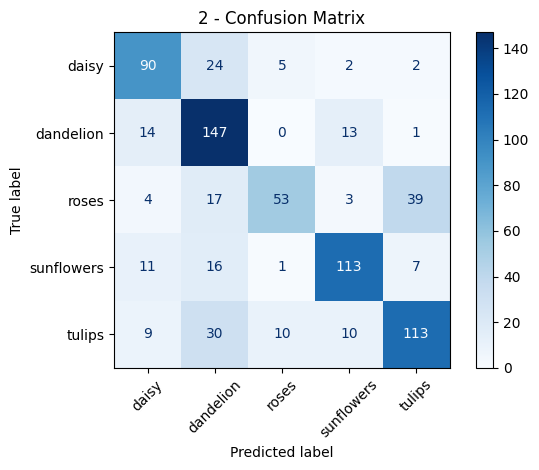

In [23]:
cfg = experiments[2]
result2 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)


Starting experiment: 3 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/12
----------------------------------------
Train loss: 1.5045 | Train acc: 0.3433
Val loss: 1.3028 | Val acc: 0.5191
Epoch train time: 20.3 s
new best model (val_loss=1.3028, val_acc=0.5191)

Epoch 2/12
----------------------------

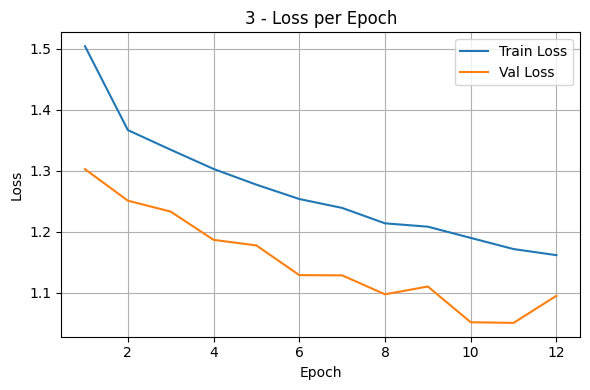

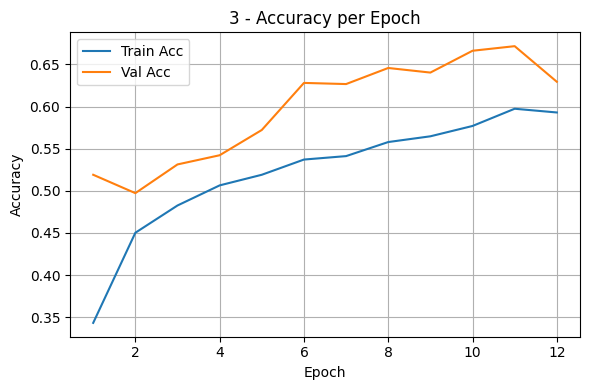

<Figure size 600x600 with 0 Axes>

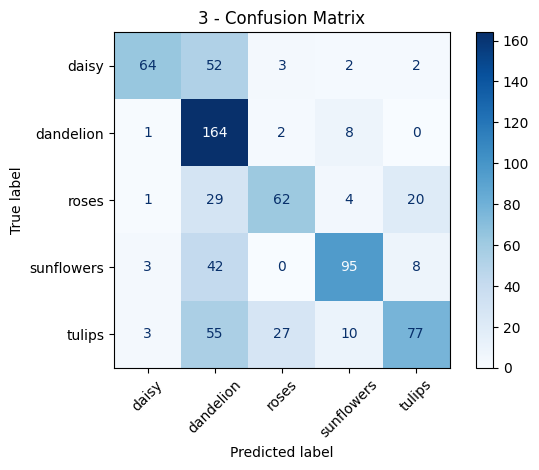

In [24]:
cfg = experiments[3]
result0 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)


Starting experiment: 4 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cla

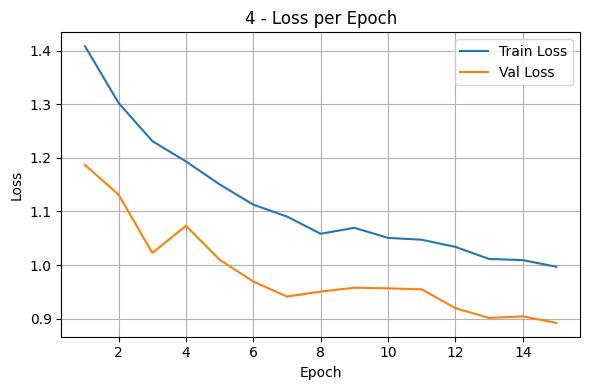

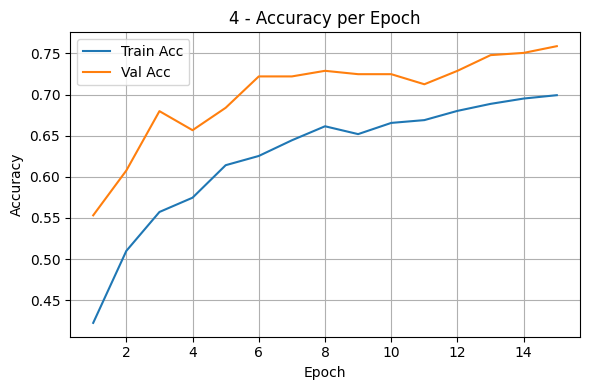

<Figure size 600x600 with 0 Axes>

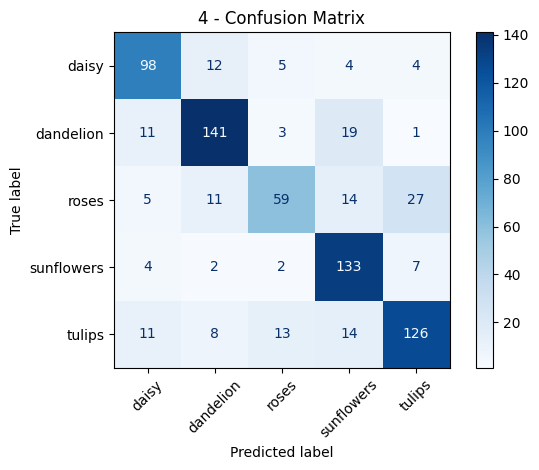

In [25]:
# CNN 3 conv + BN + pooling (modelul care deja ți-a dat ~0.76 macro-F1)
cfg = experiments[4]
result4 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)


Starting experiment: 5 on device cuda
FlexibleCNN(
  (activation): LeakyReLU(negative_slope=0.1)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Ad

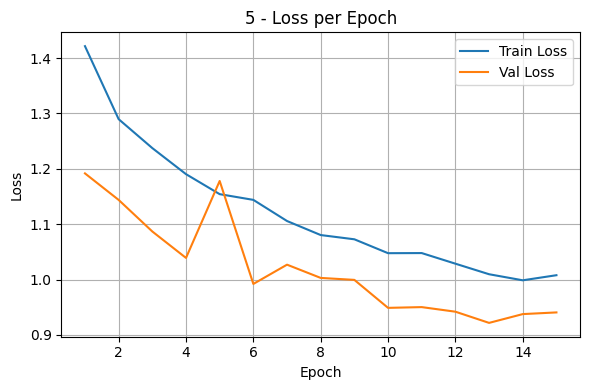

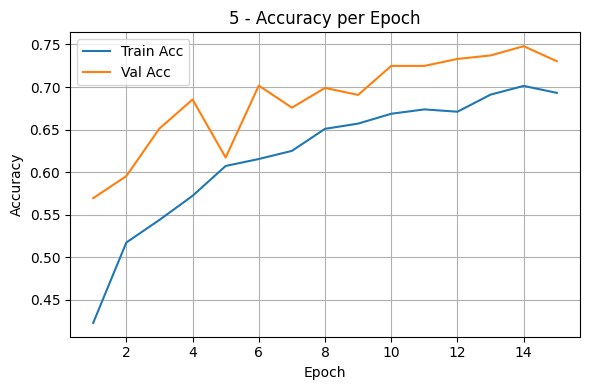

<Figure size 600x600 with 0 Axes>

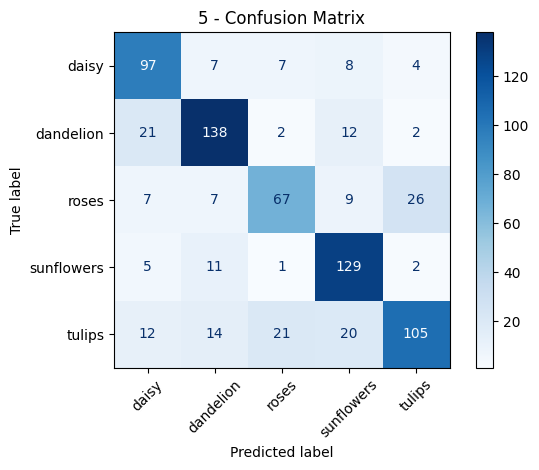

In [19]:
cfg = experiments[5]
result = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)


Starting experiment: 6 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256,

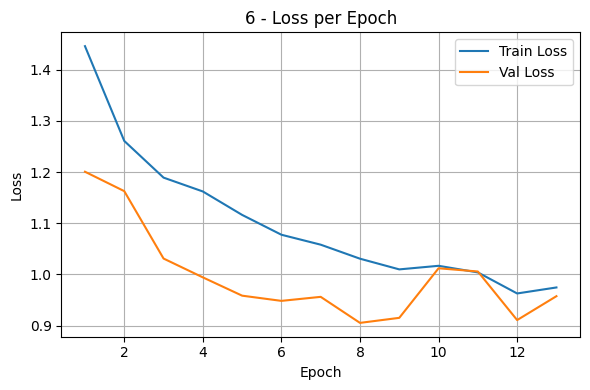

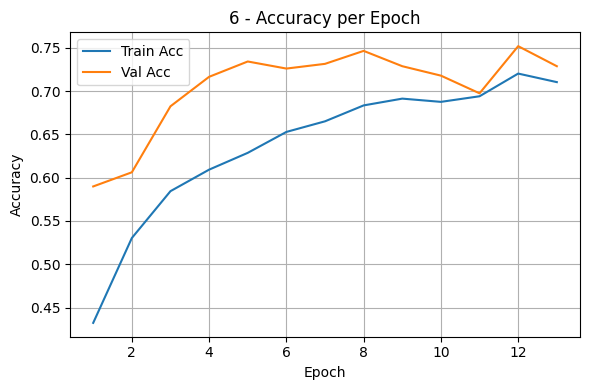

<Figure size 600x600 with 0 Axes>

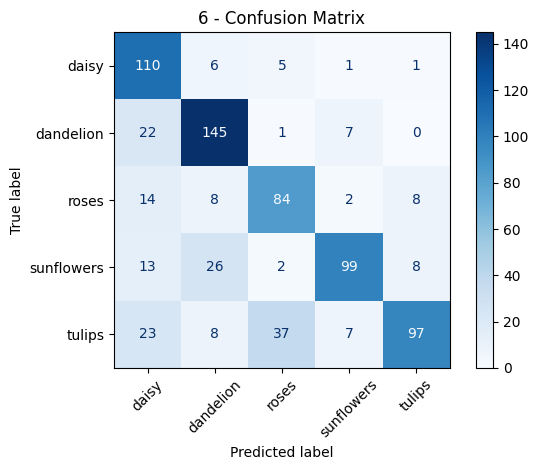

In [20]:
cfg = experiments[6]
result6 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)


Starting experiment: 7 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/8
----------------------------------------
Train loss: 1.4579 | Train acc: 0.3787
Val loss: 1.3417 | Val acc: 0.4510
Epoch train time: 57.0 s
new best model (val_loss=1.3417, val_acc=0.4510)

Epoch 2/8
----------------------------------------
Train loss: 1.3719 | Train acc: 0.4564
Val loss: 1.2216 | Val acc: 0.5749
Epoch train time: 47.0 s
new best model (val_loss=1.2216, val_acc=0.5749)

Epoch 3/

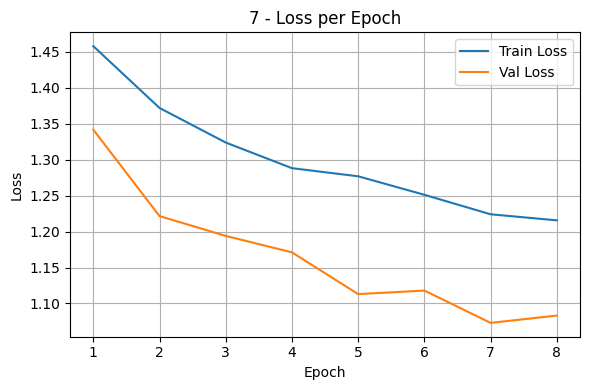

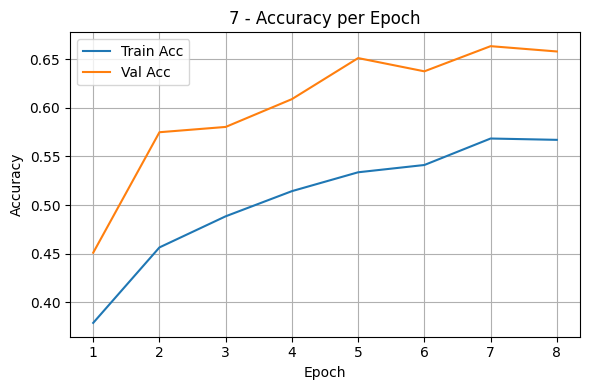

<Figure size 600x600 with 0 Axes>

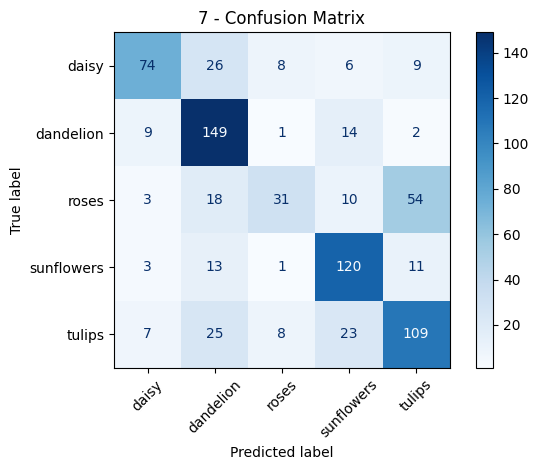

In [21]:
cfg = experiments[7]
result7 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)


Starting experiment: 8 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cla

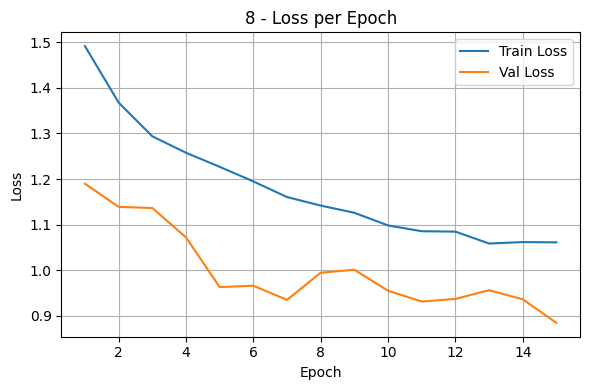

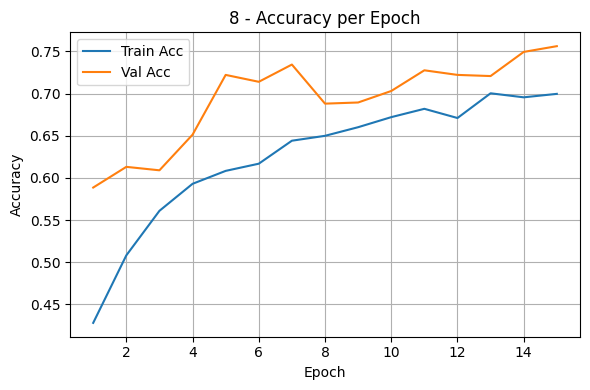

<Figure size 600x600 with 0 Axes>

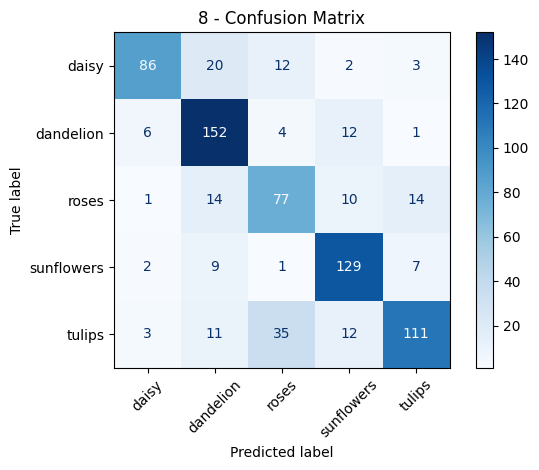

In [22]:
cfg = experiments[8]
result8 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)


Starting experiment: 9 on device cuda
FlexibleCNN(
  (activation): Tanh()
  (features): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=49152, out_features=512, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/10
----------------------------------------
Train loss: 1.5921 | Train acc: 0.3014
Val loss: 1.4547 | Val acc: 0.3719
Epoch train time: 23.9 s
new best model (val_loss=1.4547, val_acc=0.3719)

Epoch 2/10
----------------------------------------
Train loss: 1.5523 | Train acc: 0.3191
Val loss: 1.4314 | Val acc: 0.3801
Epoch train time: 21.7 s
new best model (val_loss=1.4314, val_acc=0.3801)

Epoch 3/10
----------------------------------------
Train loss: 1.5204 | Train acc: 0.3321
Val loss: 1.4059 | Val acc: 0.

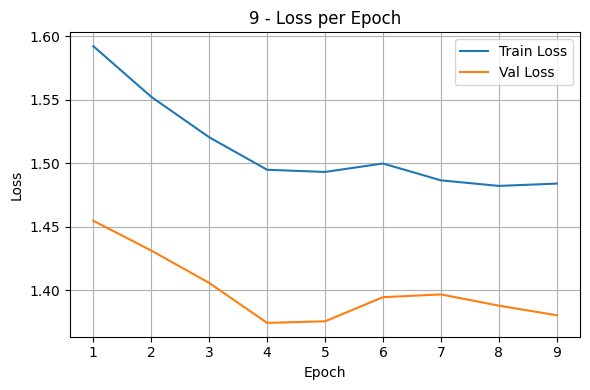

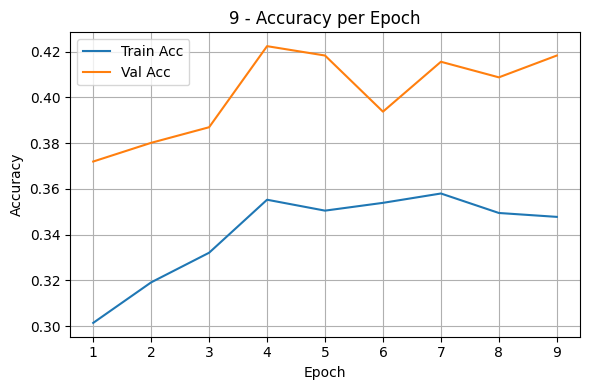

<Figure size 600x600 with 0 Axes>

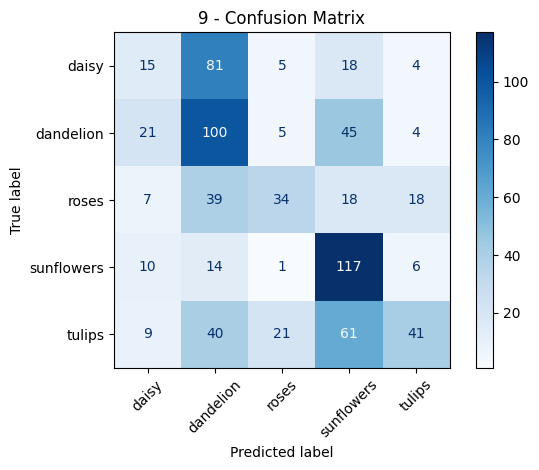

In [23]:
cfg = experiments[9]
result9 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)


Starting experiment: 10 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256

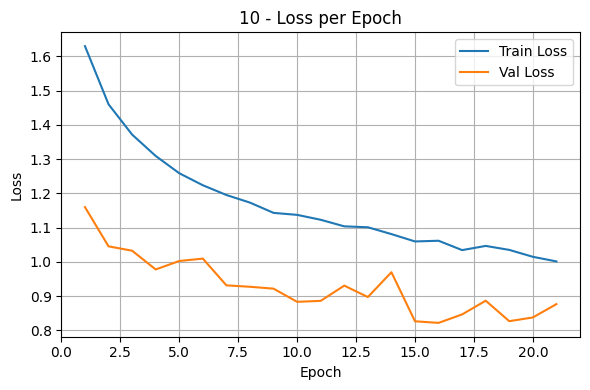

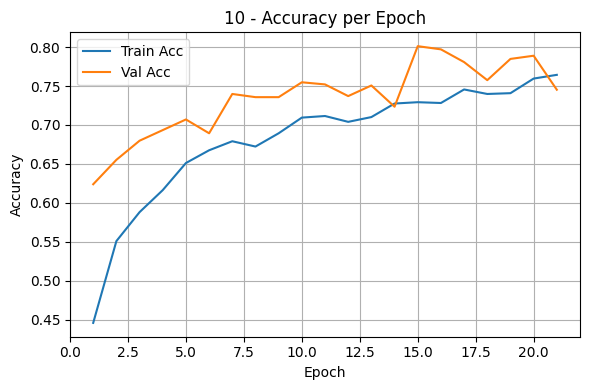

<Figure size 600x600 with 0 Axes>

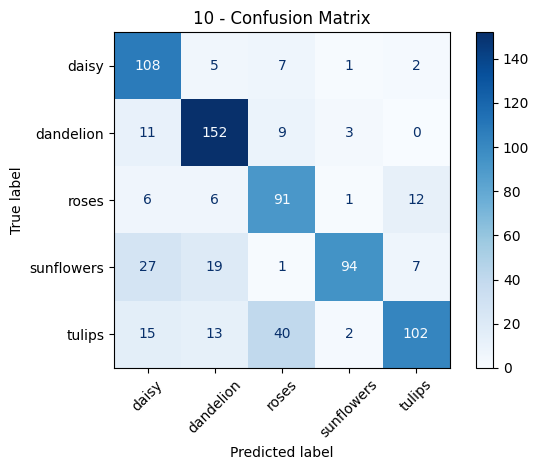

In [9]:
cfg = experiments[10]
result9 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)


Starting experiment: 11 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256

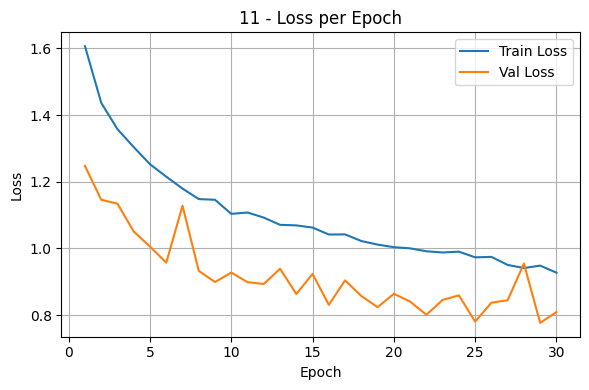

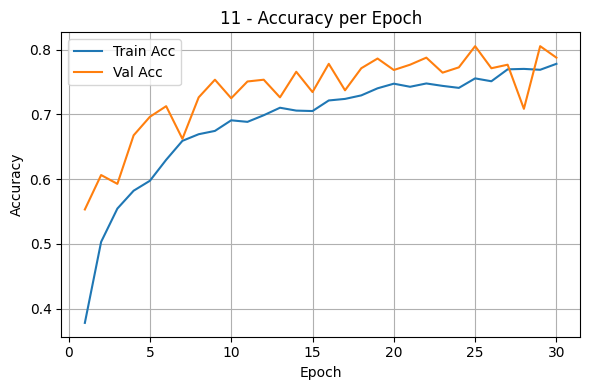

<Figure size 600x600 with 0 Axes>

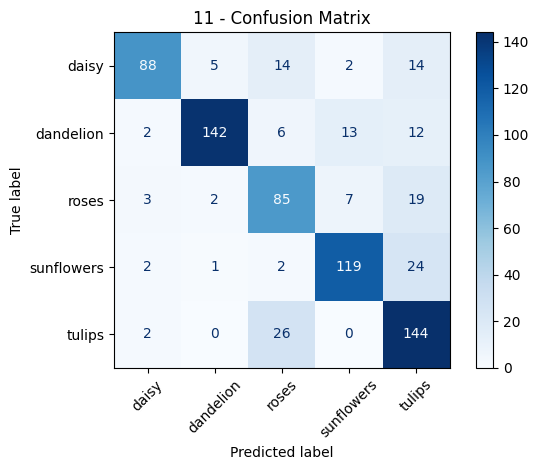

In [10]:
cfg = experiments[11]
result9 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)


Starting experiment: 12 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256

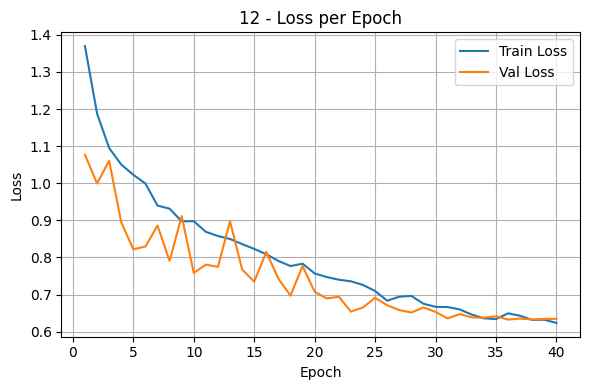

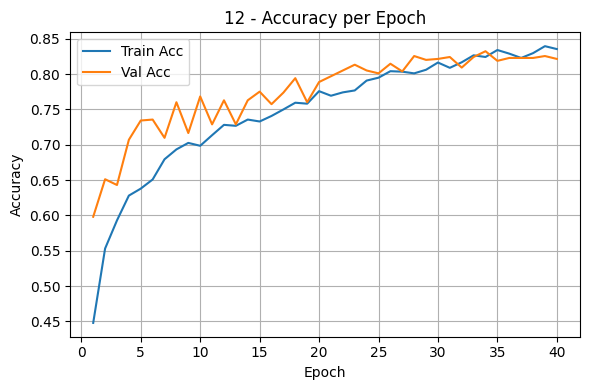

<Figure size 600x600 with 0 Axes>

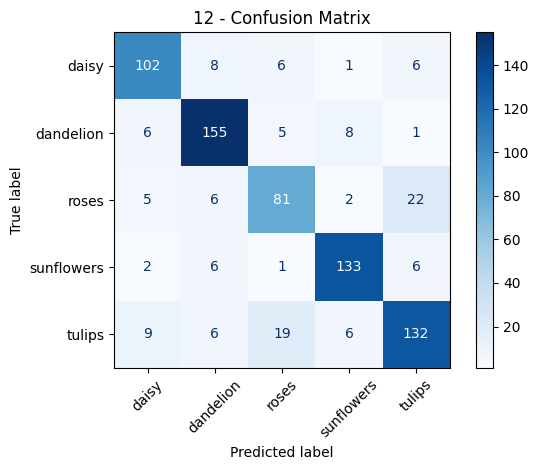

In [10]:
cfg = experiments[12]
result9 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)


===== CPU vs GPU comparison for config: 4 =====

### Running on CPU ###

Starting experiment: 4 on device cpu
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(outp

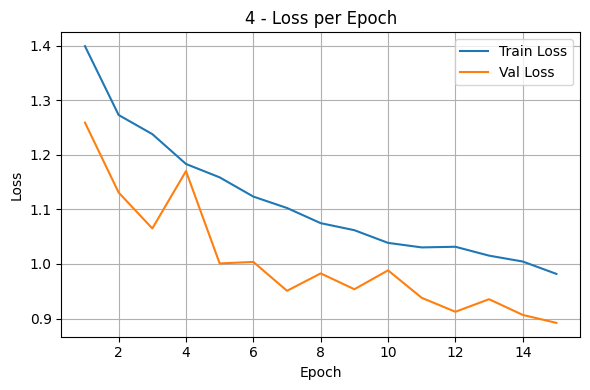

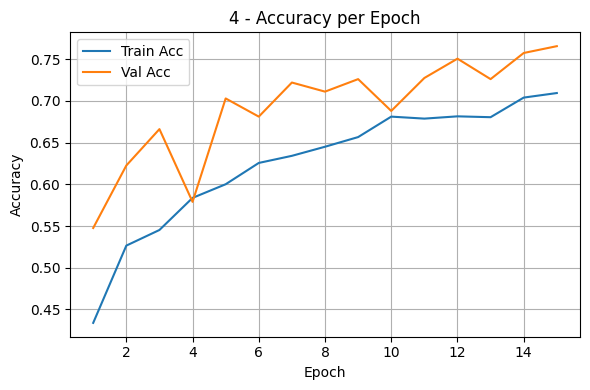

<Figure size 600x600 with 0 Axes>

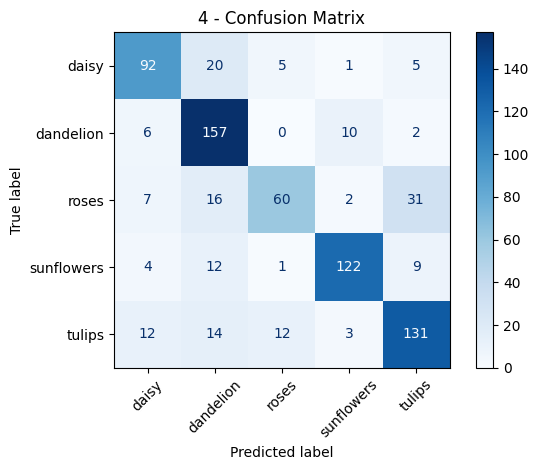


### Running on GPU ###

Starting experiment: 4 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_d

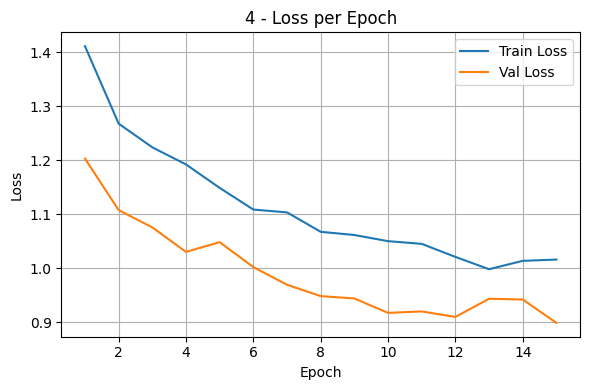

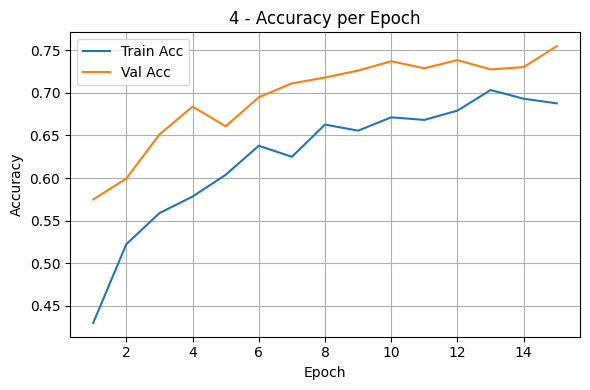

<Figure size 600x600 with 0 Axes>

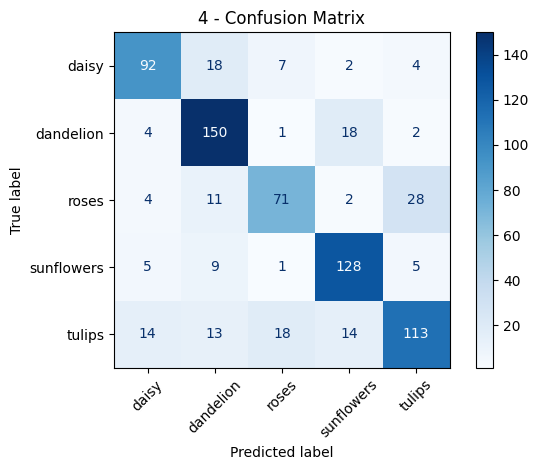


=== CPU vs GPU summary ===
CPU total time: 1267.0 s
GPU total time: 344.2 s
Approx. speedup: 3.68x


In [11]:
best_cfg_for_speed = next(
    e for e in experiments
    if e.name == "4"
)

compare_cpu_gpu(best_cfg_for_speed, train_loader, val_loader, class_names, num_classes)


EXTRA CU ResNet

TRAINING FINISHED FOR resnet18_transfer_frozen
Best epoch: 15 / 15
Best val_loss: 0.6620 | Best val_acc: 0.8787
Total training time: 620.7 s
Macro-F1 on validation: 0.8750

In [12]:
from torchvision import models

def get_dataloaders_resnet(batch_size=32):
    image_size_resnet = 224

    train_transform_resnet = transforms.Compose([
        transforms.RandomResizedCrop(size=image_size_resnet, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    val_transform_resnet = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size_resnet),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    base_dataset = datasets.ImageFolder(root=data_dir)
    class_names = base_dataset.classes
    num_classes = len(class_names)

    print("Classes:", class_names)
    print("Number of images:", len(base_dataset))

    train_ratio = 0.8
    train_size = int(train_ratio * len(base_dataset))
    val_size = len(base_dataset) - train_size

    train_subset_base, val_subset_base = random_split(
        base_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42),
    )

    train_indices = train_subset_base.indices
    val_indices = val_subset_base.indices

    full_train_dataset_resnet = datasets.ImageFolder(root=data_dir, transform=train_transform_resnet)
    full_val_dataset_resnet = datasets.ImageFolder(root=data_dir, transform=val_transform_resnet)

    train_dataset_resnet = Subset(full_train_dataset_resnet, train_indices)
    val_dataset_resnet = Subset(full_val_dataset_resnet, val_indices)

    print(f"[ResNet] Train size: {len(train_dataset_resnet)}, Val size: {len(val_dataset_resnet)}")

    train_loader_resnet = DataLoader(
        train_dataset_resnet,
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader_resnet = DataLoader(
        val_dataset_resnet,
        batch_size=batch_size,
        shuffle=False,
    )

    print("[ResNet] Number of train batches:", len(train_loader_resnet))
    print("[ResNet] Number of val batches:", len(val_loader_resnet))

    return train_loader_resnet, val_loader_resnet, class_names, num_classes

In [13]:
train_loader_resnet, val_loader_resnet, class_names_resnet, num_classes_resnet = get_dataloaders_resnet(batch_size=32)

Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of images: 3670
[ResNet] Train size: 2936, Val size: 734
[ResNet] Number of train batches: 92
[ResNet] Number of val batches: 23


In [14]:
from torchvision.models import resnet18, ResNet18_Weights

class ResNetTransfer(nn.Module):
    def __init__(self, num_classes: int, freeze_backbone: bool = True):
        super().__init__()
        # Backbone cu weights ImageNet
        self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        num_feats = self.backbone.fc.in_features

        # Scoatem fc original și punem classifier-ul nostru
        self.backbone.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(num_feats, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # doar classifier-ul rămâne trainable
        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.backbone(x)   # ieșire [batch, 512]
        x = self.classifier(x)
        return x


In [15]:
resnet_model = ResNetTransfer(num_classes=num_classes_resnet, freeze_backbone=True).to(default_device)
print(resnet_model)

ResNetTransfer(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [16]:
from torch.optim.lr_scheduler import StepLR


@dataclass
class ResNetConfig:
    name: str = "resnet18_transfer_frozen"
    learning_rate: float = 1e-3     # mai mare, doar classifier-ul e antrenat
    l2_lambda: float = 1e-4
    l1_lambda: float = 0.0
    num_epochs: int = 15
    patience: int = 5

def run_resnet_experiment(
    cfg: ResNetConfig,
    train_loader: DataLoader,
    val_loader: DataLoader,
    class_names: List[str],
    num_classes: int,
    device: torch.device,
):
    print("\n" + "=" * 80)
    print(f"Starting experiment: {cfg.name} on device {device}")
    print("=" * 80)

    model = ResNetTransfer(num_classes=num_classes, freeze_backbone=True).to(device)
    print(model)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=cfg.learning_rate,
        weight_decay=cfg.l2_lambda,
    )

    #todo for 12
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "epoch_time": [],
    }

    best_val_loss = float("inf")
    best_val_acc = 0.0
    best_state_dict = None
    best_epoch = 0
    no_improve_epochs = 0

    total_start = time.time()

    for epoch in range(1, cfg.num_epochs + 1):
        print(f"\nEpoch {epoch}/{cfg.num_epochs}")
        print("-" * 40)

        train_loss, train_acc, train_time = train_one_epoch(
            model, train_loader, criterion, optimizer, device, l1_lambda=cfg.l1_lambda
        )
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["epoch_time"].append(train_time)

        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
        print(f"Epoch train time: {train_time:.1f} s")

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_state_dict = model.state_dict()
            best_epoch = epoch
            no_improve_epochs = 0
            print(f"new best model (val_loss={best_val_loss:.4f}, val_acc={best_val_acc:.4f})")
        else:
            no_improve_epochs += 1
            print(f"no improvement for {no_improve_epochs} epoch(s)")

         #todo for 12
        if scheduler is not None:
            scheduler.step()


        if no_improve_epochs >= cfg.patience:
            print(f" early stopping triggered at epoch {epoch}")
            break

    total_time = time.time() - total_start
    print(f"\nTRAINING FINISHED FOR {cfg.name}")
    print(f"Best epoch: {best_epoch} / {cfg.num_epochs}")
    print(f"Best val_loss: {best_val_loss:.4f} | Best val_acc: {best_val_acc:.4f}")
    print(f"Total training time: {total_time:.1f} s")

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    all_labels, all_preds = get_predictions(model, val_loader, device)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Macro-F1 on validation: {macro_f1:.4f}")

    print_model_parameters(model)

    plot_history(history, title_prefix=cfg.name)
    plot_confusion(all_labels, all_preds, class_names, title=f"{cfg.name} - Confusion Matrix")

    result = {
        "config": cfg,
        "history": history,
        "macro_f1": macro_f1,
        "best_val_acc": best_val_acc,
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "total_time": total_time,
    }
    return result



Starting experiment: resnet18_transfer_frozen on device cuda
ResNetTransfer(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

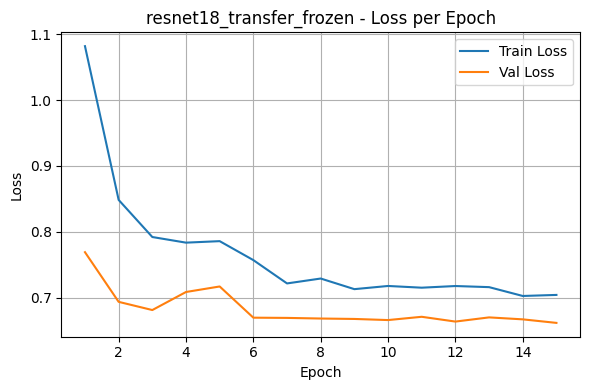

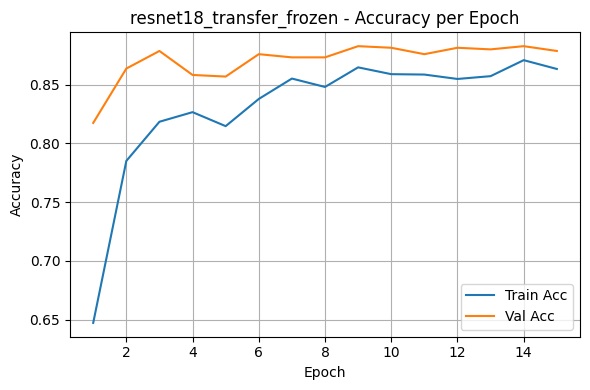

<Figure size 600x600 with 0 Axes>

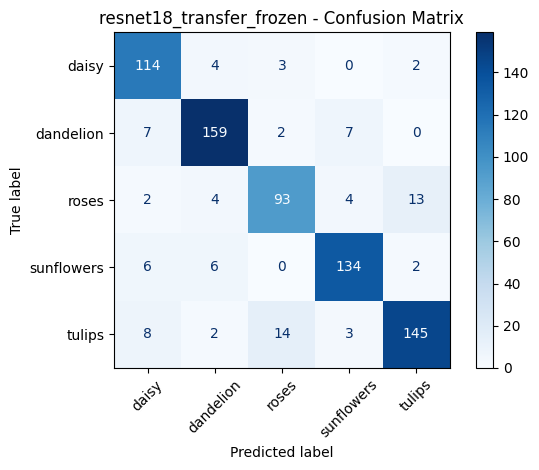

In [17]:
resnet_cfg = ResNetConfig()
resnet_result = run_resnet_experiment(
    resnet_cfg,
    train_loader_resnet,
    val_loader_resnet,
    class_names_resnet,
    num_classes_resnet,
    device=default_device,
)